In [1]:
import torch
from transformers import SamModel, SamProcessor
from PIL import Image
import numpy as np
from torchvision.transforms import Resize
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy import ndimage

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


In [7]:
def predict_and_visualize(image_path, model, processor, device):
    # Load and preprocess the image
    image = Image.open(image_path)
    image = image.resize((256, 256), Image.LANCZOS)
    image_np = np.array(image)

    # Check if the image is 2D (grayscale)
    if len(image_np.shape) == 2:
        # Convert 2D grayscale to 3D RGB
        image_np = np.stack((image_np,) * 3, axis=-1)

    # Compute cell centers using center of mass
    gray_image = np.mean(image_np, axis=2).astype(np.uint8)
    threshold = np.mean(gray_image)
    binary_image = gray_image > threshold
    labeled_image, num_features = ndimage.label(binary_image)
    
    centers = []
    for label in range(1, num_features + 1):
        center = ndimage.center_of_mass(binary_image, labeled_image, label)
        centers.append([float(center[1]), float(center[0])])  # Convert to [x, y] format and ensure float type


    # Prepare the image and point prompts for the model
    inputs = processor(image_np, input_points=[[centers]], return_tensors="pt")
    
    # Move inputs to the appropriate device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate masks
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=True)
    
     # Print the size of the predicted masks
    print(f"Predicted masks size: {outputs.pred_masks.shape}")
    
    # Apply sigmoid and convert to hard masks
    medsam_seg_probs = torch.sigmoid(outputs.pred_masks)
    medsam_seg_probs = medsam_seg_probs.cpu().numpy().squeeze()
    medsam_segs = (medsam_seg_probs > 0.5).astype(np.uint8)
    print(f"Segmentation masks shape: {medsam_segs.shape}")

    # Visualize the results
    num_masks = medsam_segs.shape[0]
    fig, axes = plt.subplots(1, num_masks + 1, figsize=(5 * (num_masks + 1), 5))
    
    # Ensure axes is always a list
    if num_masks == 0:
        axes = [axes]
    
    # Original image
    axes[0].imshow(image_np, cmap='gray' if len(image_np.shape) == 2 else None)
    axes[0].set_title("Original image")
    axes[0].axis('off')
    
    # Predicted masks
    for i in range(num_masks):
        axes[i+1].imshow(image_np, cmap='gray' if len(image_np.shape) == 2 else None)
        show_mask(medsam_segs[i], axes[i+1], random_color=True)
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')
    
   
    plt.tight_layout()
    plt.show()


Base model loaded!
Finetuned model loaded!
Predicted masks size: torch.Size([1, 1, 3, 256, 256])
Segmentation masks shape: (3, 256, 256)


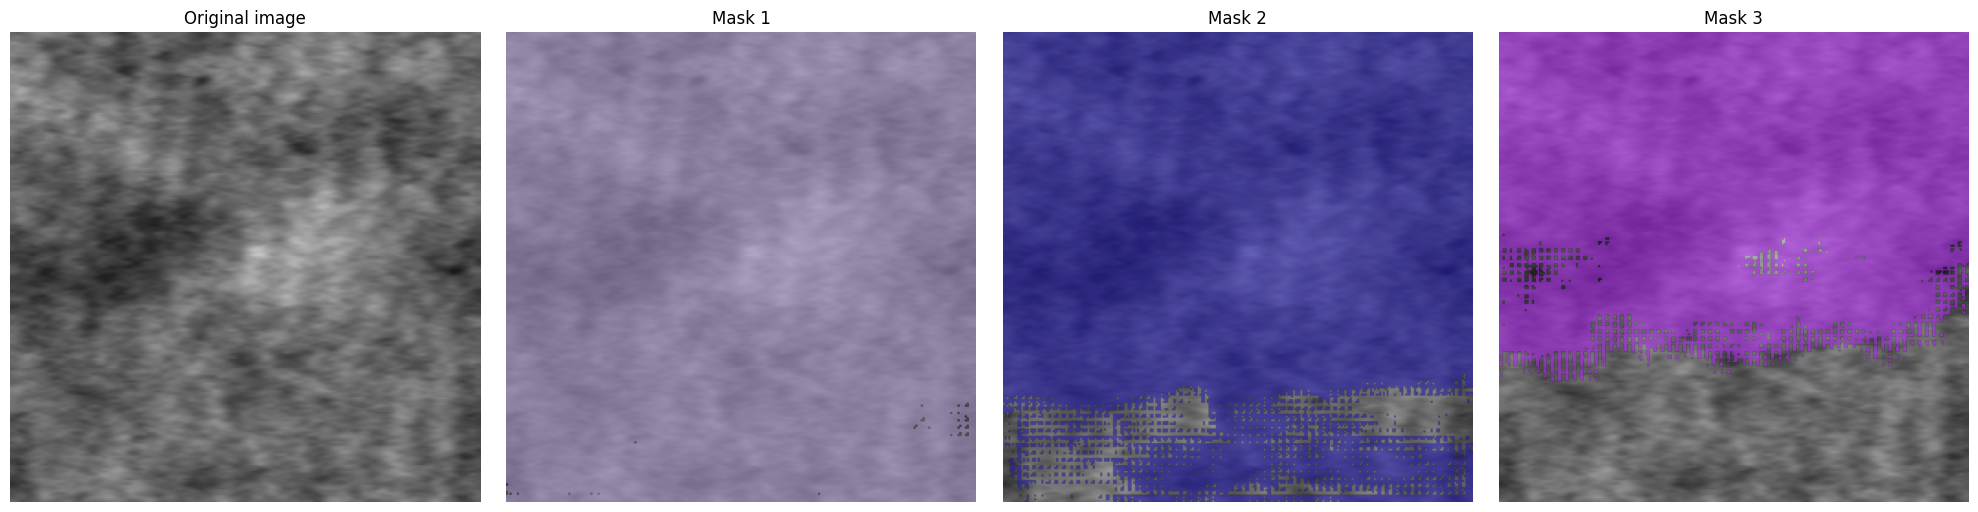

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the base model
model = SamModel.from_pretrained("wanglab/medsam-vit-base").to(device)
processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")
print('Base model loaded!')

# SAM
# processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

# model = SamModel.from_pretrained("facebook/sam-vit-huge")
# processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# Load the trained mask decoder
checkpoint = torch.load('best_mask_decoder_medsam_100.pth', map_location=device)
model.mask_decoder.load_state_dict(checkpoint['mask_decoder_state_dict'])
print('Finetuned model loaded!')

# Set the model to evaluation mode
model.eval()

# Predict on a new image
#image_path = "/home/hpc/iwi5/iwi5171h/data_processing/calculated_dataset/stardist_dataset/closest_vertex_dataset/closest_vertex_high_degree_only_120/train/images/4571_od_129_7681_4_0_calculated_ref_51_lps_8_lbss_8_sr_n_50_cropped_5_0_0.tif"
image_path = "/home/hpc/iwi5/iwi5171h/data_processing/calculated_dataset/stardist_dataset/closest_vertex_dataset/closest_vertex_high_degree_only_120/train/images/5160_od_228_19122_6_0_Medium_calculated_ref_42_lps_8_lbss_8_sr_n_30_cropped_5_0_0.tif"
#image_path = '/home/hpc/iwi5/iwi5171h/medsam_file/MedSAM/assets/dog.tiff'
predict_and_visualize(image_path, model, processor, device)